# Packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,summarize,poly)

# Importation

In [2]:
Boston = load_data("Boston")
Boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

# Estimating Y = f(lstat, age)

In [3]:
y = Boston['medv']
X = MS(['lstat', 'age']).fit_transform(Boston)
model1 = sm.OLS(y, X)
results1 = model1.fit()
summarize(results1)

,coef,std err,t,P>|t|
intercept,33.2228,0.731,45.458,0.000
lstat,-1.0321,0.048,-21.416,0.000
age,0.0345,0.012,2.826,0.005


# Estimating for all predicators

In [4]:
terms = Boston.columns.drop('medv')
terms

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat'],
      dtype='object')

In [5]:
X = MS(terms).fit_transform(Boston)
model = sm.OLS(y, X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,41.6173,4.936,8.431,0.000
crim,-0.1214,0.033,-3.678,0.000
zn,0.0470,0.014,3.384,0.001
indus,0.0135,0.062,0.217,0.829
chas,2.8400,0.870,3.264,0.001
nox,-18.7580,3.851,-4.870,0.000
rm,3.6581,0.420,8.705,0.000
age,0.0036,0.013,0.271,0.787
dis,-1.4908,0.202,-7.394,0.000
rad,0.2894,0.067,4.325,0.000


# Drop some variables with a lot of p-values

In [6]:
Boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

In [7]:
minus_age = Boston.columns.drop(['medv', 'age', 'indus'])
Xma = MS(minus_age).fit_transform(Boston)
model1 = sm.OLS(y, Xma)
summarize(model1.fit())

,coef,std err,t,P>|t|
intercept,41.4517,4.903,8.454,0.000
crim,-0.1217,0.033,-3.696,0.000
zn,0.0462,0.014,3.378,0.001
chas,2.8719,0.863,3.329,0.001
nox,-18.2624,3.565,-5.122,0.000
rm,3.6730,0.409,8.978,0.000
dis,-1.5160,0.188,-8.078,0.000
rad,0.2839,0.064,4.440,0.000
tax,-0.0123,0.003,-3.608,0.000
ptratio,-0.9310,0.130,-7.138,0.000


Maintenant, on voit que toutes les variables sont significatives. 

# Multivariate Goodness of Fit

In [8]:
vals = [VIF(X, i)
        for i in range(1, X.shape[1])]
vif = pd.DataFrame({'vif' : vals},
                   index=X.columns[1:])
vif

,vif
crim,1.767486
zn,2.298459
indus,3.987181
chas,1.071168
nox,4.369093
rm,1.912532
age,3.088232
dis,3.954037
rad,7.445301
tax,9.002158


Voici les seuils usuels : 
- VIF ≈ 1 : pas de problème
- 5–10 : multicolinéarité forte
- >10 : très problématique

L'accessibilité aux autoroutes et taxe foncière sont donc corrélées entre elles. 

In [9]:
vals = []
for i in range(1, X.values.shape[1]) : 
    vals.append(VIF(X.values, i))
vals

[np.float64(1.7674859154310125),
 np.float64(2.2984589077358097),
 np.float64(3.9871806307570994),
 np.float64(1.0711677737584042),
 np.float64(4.369092622844793),
 np.float64(1.9125324374368864),
 np.float64(3.0882320397311984),
 np.float64(3.954036641628298),
 np.float64(7.445300760069838),
 np.float64(9.002157663471797),
 np.float64(1.797059593129779),
 np.float64(2.8707765008417496)]

# Interaction terms

In [10]:
X = MS(['lstat', 
        'age',
        ('lstat', 'age')]).fit_transform(Boston)
model2 = sm.OLS(y, X)
summarize(model2.fit())

,coef,std err,t,P>|t|
intercept,36.0885,1.470,24.553,0.000
lstat,-1.3921,0.167,-8.313,0.000
age,-0.0007,0.020,-0.036,0.971
lstat:age,0.0042,0.002,2.244,0.025


Les coefficients liés à lstat et age sont des coefficients indépendants. Par exemple, une augmentation d'un point de pourcentage de la part de population à bas socio-économique est associée à une baisse d'environ de 1 400 dollars de valeur médiane des maisons.

L'effet d'interraction positif signifie que l'âge de la maison réduit l'effet negatif de lstat sur y puisque −1.3921+0.0042×age. Ainsi, l’effet négatif de lstat sur le prix des maisons est plus faible dans les quartiers anciens que dans les quartiers récents.

# 3.6.6 Non-linear Transformations of the Predictors

In [11]:
X = MS([poly('lstat', degree=2), 'age']).fit_transform(Boston)
model3 = sm.OLS(y, X)
results3 = model3.fit()
summarize(results3)

,coef,std err,t,P>|t|
intercept,17.7151,0.781,22.681,0.0
"poly(lstat, degree=2)[0]",-179.2279,6.733,-26.620,0.0
"poly(lstat, degree=2)[1]",72.9908,5.482,13.315,0.0
age,0.0703,0.011,6.471,0.0


In [12]:
anova_lm(results1, results3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,503.0,19168.128609,0.0,NaN,NaN,NaN
1,502.0,14165.613251,1.0,5002.515357,177.278785,7.468491e-35


Le modèle 1 améliore significativement le modèle 0 : l’erreur diminue fortement et le test F est très élevé avec une p-value quasi nulle.
Celà signifie que la non-linéarité a pu mieux ajuster la relation entre lstat et medv comme on a vu dans le scatter plot (3.6.2). 

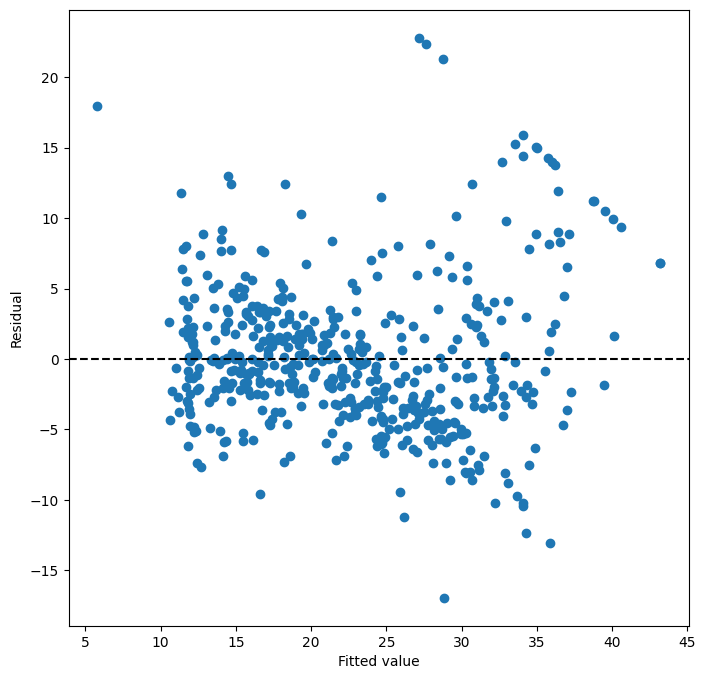

In [13]:
ax = subplots(figsize=(8,8))[1]
ax.scatter(results3.fittedvalues, results3.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--')

# 3.6.7. Quadratic Predictors

In [14]:
Carseats = load_data('Carseats')
Carseats.columns

Index(['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [15]:
allvars = list(Carseats.columns.drop('Sales'))
y = Carseats['Sales']
final = allvars + [('Income', 'Advertising'),
('Price', 'Age')]
X = MS(final).fit_transform(Carseats)
model = sm.OLS(y, X)
summarize(model.fit())

,coef,std err,t,P>|t|
intercept,6.5756,1.009,6.519,0.000
CompPrice,0.0929,0.004,22.567,0.000
Income,0.0109,0.003,4.183,0.000
Advertising,0.0702,0.023,3.107,0.002
Population,0.0002,0.000,0.433,0.665
Price,-0.1008,0.007,-13.549,0.000
ShelveLoc[Good],4.8487,0.153,31.724,0.000
ShelveLoc[Medium],1.9533,0.126,15.531,0.000
Age,-0.0579,0.016,-3.633,0.000
Education,-0.0209,0.020,-1.063,0.288
